In [51]:
# pip install newspaper3k
# pip install gnews
# pip install gradio
# pip install elevenlabs
# pip install openai
# pip install langchain

In [52]:
import os
import json
import gnews
import openai
import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from langchain.docstore.document import Document
from langchain.chains.summarize import load_summarize_chain
from pydub import AudioSegment
from networkx.algorithms import community
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import PyPDFLoader
from elevenlabs import voices, generate, play, save
from langchain import OpenAI
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain.prompts import PromptTemplate
from langchain.chains.llm import LLMChain
from langchain.embeddings import OpenAIEmbeddings
from pygooglenews import GoogleNews
from dotenv import load_dotenv
from datetime import datetime
from scipy.spatial.distance import cosine
load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY")
gn = GoogleNews()
eleven_api_key = "cfca92285bd4a2238aadd6efc15ab464"

In [53]:
def gen_article_text(topic, env="prod"):
    article_titles = list()
    article_body = list()
    if(env == "prod"):
        # google_news = gnews.GNews(period='7d', max_results=10)
        google_news = gnews.GNews(language='en', country='Sweden', period='7d', max_results=10)
        news_response = google_news.get_news(topic) # En lista av artikelobjekt, article.text, article.title
        print(news_response)
        for news in news_response:
            full_article = google_news.get_full_article(news['url'])
            print("-----")
            print(full_article)
            if(full_article and (full_article.title and full_article.text)):
                article_titles.append(full_article.title)
                article_body.append(full_article.text)
        with open('./tmp/articles.txt', 'w') as f:   
            for i in range(len(article_titles)):
                if(i != 0):
                    f.write(f"********\n")
                f.write(f"{article_titles[i]}\n")
                f.write(f"********\n")
                f.write(f"{article_body[i]}\n")
    elif(env == "test"):
        with open('./tmp/articles.txt') as f:
            lines = f.readlines()
            lines = ''.join([line.strip() for line in lines])
            lines = lines.split("********")
            for i in range(len(lines)):
                line = lines[i]
                if(i % 2 == 0):
                    article_titles.append(line)
                else:
                    article_body.append(line)
    # print(article_titles)
    # print(article_body)
    combined_text = ""
    for article in article_body:
        combined_text += article
    
    return combined_text

In [54]:
def gen_segments(topic, environment):
    text = gen_article_text(topic, environment)
    # Get segments from txt by splitting on .
    segments =  text.split('.')
    # Put the . back in
    segments = [segment + '.' for segment in segments]
    # Further split by comma
    segments = [segment.split(',') for segment in segments]
    # Flatten
    segments = [item for sublist in segments for item in sublist]
    return segments

In [55]:
def create_sentences(segments, MIN_WORDS, MAX_WORDS):
    
  # Combine the non-sentences together
  sentences = []

  is_new_sentence = True
  sentence_length = 0
  sentence_num = 0
  sentence_segments = []

  for i in range(len(segments)):
    if is_new_sentence == True:
      is_new_sentence = False
    # Append the segment
    sentence_segments.append(segments[i])
    segment_words = segments[i].split(' ')
    sentence_length += len(segment_words)
    
    # If exceed MAX_WORDS, then stop at the end of the segment
    # Only consider it a sentence if the length is at least MIN_WORDS
    if (sentence_length >= MIN_WORDS and segments[i][-1] == '.') or sentence_length >= MAX_WORDS:
      sentence = ' '.join(sentence_segments)
      sentences.append({
        'sentence_num': sentence_num,
        'text': sentence,
        'sentence_length': sentence_length
      })
      # Reset
      is_new_sentence = True
      sentence_length = 0
      sentence_segments = []
      sentence_num += 1

  return sentences

def create_chunks(sentences, CHUNK_LENGTH, STRIDE):

  sentences_df = pd.DataFrame(sentences)
  
  chunks = []
  for i in range(0, len(sentences_df), (CHUNK_LENGTH - STRIDE)):
    chunk = sentences_df.iloc[i:i+CHUNK_LENGTH]
    chunk_text = ' '.join(chunk['text'].tolist())
    
    chunks.append({
      'start_sentence_num': chunk['sentence_num'].iloc[0],
      'end_sentence_num': chunk['sentence_num'].iloc[-1],
      'text': chunk_text,
      'num_words': len(chunk_text.split(' '))
    })
    
  chunks_df = pd.DataFrame(chunks)
  return chunks_df.to_dict('records')

def parse_title_summary_results(results):
  out = []
  for e in results:
    e = e.replace('\n', '')
    if '|' in e:
      processed = {'title': e.split('|')[0],
                    'summary': e.split('|')[1][1:]
                    }
    elif ':' in e:
      processed = {'title': e.split(':')[0],
                    'summary': e.split(':')[1][1:]
                    }
    elif '-' in e:
      processed = {'title': e.split('-')[0],
                    'summary': e.split('-')[1][1:]
                    }
    else:
      processed = {'title': '',
                    'summary': e
                    }
    out.append(processed)
  return out

In [56]:
def summarize_stage_1(chunks_text):
      
  print(f'Start time: {datetime.now()}')

  # Prompt to get title and summary for each chunk
  map_prompt_template = """Firstly, give the following text an informative title. Then, on a new line, write a 75-100 word summary of the following text:
  {text}

  Return your answer in the following format:
  Title | Summary...
  e.g. 
  Why Artificial Intelligence is Good | AI can make humans more productive by automating many repetitive processes.

  TITLE AND CONCISE SUMMARY:"""

  map_prompt = PromptTemplate(template=map_prompt_template, input_variables=["text"])

  # Define the LLMs
  map_llm = OpenAI(temperature=0, model_name = 'text-davinci-003')
  map_llm_chain = LLMChain(llm = map_llm, prompt = map_prompt)
  map_llm_chain_input = [{'text': t} for t in chunks_text]
  # Run the input through the LLM chain (works in parallel)
  map_llm_chain_results = map_llm_chain.apply(map_llm_chain_input)

  stage_1_outputs = parse_title_summary_results([e['text'] for e in map_llm_chain_results])

  print(f'Stage 1 done time {datetime.now()}')

  return {
    'stage_1_outputs': stage_1_outputs
  }

In [57]:
# Run the community detection algorithm

def get_topics(title_similarity, num_topics = 8, bonus_constant = 0.25, min_size = 3):

  proximity_bonus_arr = np.zeros_like(title_similarity)
  for row in range(proximity_bonus_arr.shape[0]):
    for col in range(proximity_bonus_arr.shape[1]):
      if row == col:
        proximity_bonus_arr[row, col] = 0
      else:
        proximity_bonus_arr[row, col] = 1/(abs(row-col)) * bonus_constant
        
  title_similarity += proximity_bonus_arr

  title_nx_graph = nx.from_numpy_array(title_similarity)

  desired_num_topics = num_topics
  # Store the accepted partitionings
  topics_title_accepted = []

  resolution = 0.85
  resolution_step = 0.01
  iterations = 40

  # Find the resolution that gives the desired number of topics
  topics_title = []
  while len(topics_title) not in [desired_num_topics, desired_num_topics + 1, desired_num_topics + 2]:
    topics_title = community.louvain_communities(title_nx_graph, weight = 'weight', resolution = resolution)
    resolution += resolution_step
  topic_sizes = [len(c) for c in topics_title]
  sizes_sd = np.std(topic_sizes)
  modularity = community.modularity(title_nx_graph, topics_title, weight = 'weight', resolution = resolution)

  lowest_sd_iteration = 0
  # Set lowest sd to inf
  lowest_sd = float('inf')

  for i in range(iterations):
    topics_title = community.louvain_communities(title_nx_graph, weight = 'weight', resolution = resolution)
    modularity = community.modularity(title_nx_graph, topics_title, weight = 'weight', resolution = resolution)
    
    # Check SD
    topic_sizes = [len(c) for c in topics_title]
    sizes_sd = np.std(topic_sizes)
    
    topics_title_accepted.append(topics_title)
    
    if sizes_sd < lowest_sd and min(topic_sizes) >= min_size:
      lowest_sd_iteration = i
      lowest_sd = sizes_sd
      
  # Set the chosen partitioning to be the one with highest modularity
  topics_title = topics_title_accepted[lowest_sd_iteration]
  print(f'Best SD: {lowest_sd}, Best iteration: {lowest_sd_iteration}')
  
  topic_id_means = [sum(e)/len(e) for e in topics_title]
  # Arrange title_topics in order of topic_id_means
  topics_title = [list(c) for _, c in sorted(zip(topic_id_means, topics_title), key = lambda pair: pair[0])]
  # Create an array denoting which topic each chunk belongs to
  chunk_topics = [None] * title_similarity.shape[0]
  for i, c in enumerate(topics_title):
    for j in c:
      chunk_topics[j] = i
            
  return {
    'chunk_topics': chunk_topics,
    'topics': topics_title
    }

In [58]:
def summarize_stage_2(stage_1_outputs, topics, summary_num_words = 250):
  print(f'Stage 2 start time {datetime.now()}')
  
  # Prompt that passes in all the titles of a topic, and asks for an overall title of the topic
  title_prompt_template = """Write an informative title that summarizes each of the following groups of titles. Make sure that the titles capture as much information as possible, 
  and are different from each other:
  {text}
  
  Return your answer in a numbered list, with new line separating each title: 
  1. Title 1
  2. Title 2
  3. Title 3

  TITLES:
  """

  map_prompt_template = """Wite a 75-100 word summary of the following text:
    {text}

    CONCISE SUMMARY:"""

  combine_prompt_template = 'Write a ' + str(summary_num_words) + """-word summary of the following, removing irrelevant information. Finish your answer:
  {text}
  """ + str(summary_num_words) + """-WORD SUMMARY:"""

  title_prompt = PromptTemplate(template=title_prompt_template, input_variables=["text"])
  map_prompt = PromptTemplate(template=map_prompt_template, input_variables=["text"])
  combine_prompt = PromptTemplate(template=combine_prompt_template, input_variables=["text"])

  topics_data = []
  for c in topics:
    topic_data = {
      'summaries': [stage_1_outputs[chunk_id]['summary'] for chunk_id in c],
      'titles': [stage_1_outputs[chunk_id]['title'] for chunk_id in c]
    }
    topic_data['summaries_concat'] = ' '.join(topic_data['summaries'])
    topic_data['titles_concat'] = ', '.join(topic_data['titles'])
    topics_data.append(topic_data)
    
  # Get a list of each community's summaries (concatenated)
  topics_summary_concat = [c['summaries_concat'] for c in topics_data]
  topics_titles_concat = [c['titles_concat'] for c in topics_data]

  # Concat into one long string to do the topic title creation
  topics_titles_concat_all = ''''''
  for i, c in enumerate(topics_titles_concat):
    topics_titles_concat_all += f'''{i+1}. {c}
    '''
  
  # print('topics_titles_concat_all', topics_titles_concat_all)

  title_llm = OpenAI(temperature=0, model_name = 'text-davinci-003')
  title_llm_chain = LLMChain(llm = title_llm, prompt = title_prompt)
  title_llm_chain_input = [{'text': topics_titles_concat_all}]
  title_llm_chain_results = title_llm_chain.apply(title_llm_chain_input)
  
  
  # Split by new line
  titles = title_llm_chain_results[0]['text'].split('\n')
  # Remove any empty titles
  titles = [t for t in titles if t != '']
  # Remove spaces at start or end of each title
  titles = [t.strip() for t in titles]

  map_llm = OpenAI(temperature=0, model_name = 'text-davinci-003')
  reduce_llm = OpenAI(temperature=0, model_name = 'text-davinci-003', max_tokens = -1)

  # Run the map-reduce chain
  docs = [Document(page_content=t) for t in topics_summary_concat]
  chain = load_summarize_chain(chain_type="map_reduce", map_prompt = map_prompt, combine_prompt = combine_prompt, return_intermediate_steps = True,
                              llm = map_llm, reduce_llm = reduce_llm)

  output = chain({"input_documents": docs}, return_only_outputs = True)
  summaries = output['intermediate_steps']
  stage_2_outputs = [{'title': t, 'summary': s} for t, s in zip(titles, summaries)]
  final_summary = output['output_text']

  # Return: stage_1_outputs (title and summary), stage_2_outputs (title and summary), final_summary, chunk_allocations
  out = {
    'stage_2_outputs': stage_2_outputs,
    'final_summary': final_summary
  }
  print(f'Stage 2 done time {datetime.now()}')
  
  return out

In [59]:
def podify(style, titles, summary, topic, lang):
    chat_model = ChatOpenAI(model_name='gpt-3.5-turbo-16k') # Must have set API key as env var
    prompt = f'You are gonna generate a transcript for a podcast covering the following topics {titles}. Here is the content of all topics summarised {summary}. The transcription needs to be in {lang}. The transcrption should be in the style of {style}. Start your response with the following: You are listening to an AI-generated podcast on the theme {topic}, provided to you by PerfectPod AI: Be natural and discuss the themes and topics discussed a way that a podcast would. Dont introduce every topic one by one but connect them in a natural way.'
    text = chat_model.predict(prompt)
    return text

def audiofy(voice, text):  
    audio_voice = voice.split()[0]
    audio = generate(text=text, voice=audio_voice, model="eleven_monolingual_v1", api_key=eleven_api_key)
    save(audio, "news_audio/ADAM.wav")
    return audio

# Save audiofile
def save_audio(audio, num_minutes):
    if not os.path.exists("news_audio"):
        os.makedirs("news_audio")

    # Handling identical file names
    # file_suffix = 0
    # while os.path.exists("news_audio/summary_in_{}_mins_{}.wav".format(num_minutes, file_suffix)):
    #     file_suffix +=1

    save(audio, "news_audio/ADAM.wav")

In [60]:
# voice = "Mimi (SWE)"
# audio_voice = voice.split()[0]
# summary_lang = "English"
# if voice.split()[1] == "(SWE)":
#     summary_lang = "Swedish"
# if voice.split()[1] == "(IT)":
#     summary_lang = "Italian"

# pod_transcript = podify("Explain this to me like I'm a University student from Sweden", stage_2_titles, final_summary, "Sverige", summary_lang)


Start time: 2023-10-11 12:19:11.231937
Stage 1 done time 2023-10-11 12:19:31.338574
Best SD: 3.8188130791298667, Best iteration: 9
Stage 2 start time 2023-10-11 12:19:37.154846
Stage 2 done time 2023-10-11 12:20:00.765021
You are listening to an AI-generated podcast on the theme of escalating conflict in the Middle East. Today, we'll be covering a range of topics related to the ongoing clashes between Israel and Gaza. It's a very complex and sensitive issue, so we'll try our best to explain it in a way that's easy to understand.

Let's start with the recent declaration of war by Israeli Prime Minister Benjamin Netanyahu. This came after Palestinian militants in Gaza fired rockets and took hostages. The Israeli military reported a staggering 2,200 rockets launched from Gaza, resulting in the tragic deaths of 200 Israelis and leaving 1,452 wounded. On the other side, the Palestinian health ministry reported that 232 Palestinians were killed and 1,697 injured. These numbers are truly hear

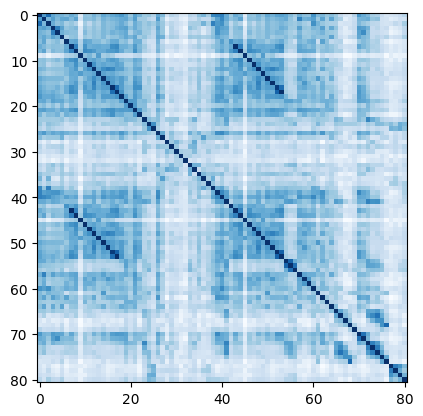

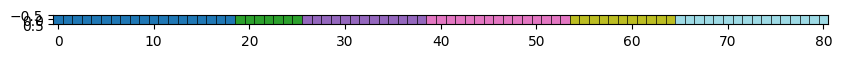

In [61]:
# audio = audiofy(voice, pod_transcript[:102])

# def test():
#     return audio
%matplotlib inline
def combined_run(topic):
    # Generate segments from 10 news articles and turn into chunks
    segments = gen_segments(topic, "test")
    sentences = create_sentences(segments, MIN_WORDS=20, MAX_WORDS=80)
    chunks = create_chunks(sentences, CHUNK_LENGTH=5, STRIDE=1)
    chunks_text = [chunk['text'] for chunk in chunks]

    # Run Stage 1 Summarizing
    stage_1_outputs = summarize_stage_1(chunks_text)['stage_1_outputs']
    # Split the titles and summaries
    stage_1_summaries = [e['summary'] for e in stage_1_outputs]
    stage_1_titles = [e['title'] for e in stage_1_outputs]
    num_1_chunks = len(stage_1_summaries)

    # Use OpenAI to embed the summaries and titles. Size of _embeds: (num_chunks x 1536)
    openai_embed = OpenAIEmbeddings()

    summary_embeds = np.array(openai_embed.embed_documents(stage_1_summaries))
    title_embeds = np.array(openai_embed.embed_documents(stage_1_titles))

    # Get similarity matrix between the embeddings of the chunk summaries
    summary_similarity_matrix = np.zeros((num_1_chunks, num_1_chunks))
    summary_similarity_matrix[:] = np.nan

    for row in range(num_1_chunks):
        for col in range(row, num_1_chunks):
            # Calculate cosine similarity between the two vectors
            similarity = 1- cosine(summary_embeds[row], summary_embeds[col])
            summary_similarity_matrix[row, col] = similarity
            summary_similarity_matrix[col, row] = similarity

    # Draw a heatmap with the summary_similarity_matrix
    plt.figure()
    # Color scheme blues
    plt.imshow(summary_similarity_matrix, cmap = 'Blues')
    # Set num_topics to be 1/4 of the number of chunks, or 8, which ever is smaller
    num_topics = 4 #min(int(num_1_chunks / 4), 8)
    topics_out = get_topics(summary_similarity_matrix, num_topics = num_topics, bonus_constant = 0.2)
    chunk_topics = topics_out['chunk_topics']
    topics = topics_out['topics']

    # Plot a heatmap of this array
    plt.figure(figsize = (10, 4))
    plt.imshow(np.array(chunk_topics).reshape(1, -1), cmap = 'tab20')
    # Draw vertical black lines for every 1 of the x-axis 
    for i in range(1, len(chunk_topics)):
        plt.axvline(x = i - 0.5, color = 'black', linewidth = 0.5)

    # Query GPT-3 to get a summarized title for each topic_data
    out = summarize_stage_2(stage_1_outputs, topics, summary_num_words = 250)
    stage_2_outputs = out['stage_2_outputs']
    stage_2_titles = [e['title'] for e in stage_2_outputs]
    stage_2_summaries = [e['summary'] for e in stage_2_outputs]
    final_summary = out['final_summary']

    stage_2_outputs
    stage_2_titles
    final_summary

    pod_transcript = podify("ELI5", stage_2_titles, final_summary, topic, "English")
    print(pod_transcript)
    
combined_run("test")

Start time: 2023-10-11 11:48:12.241773
Stage 1 done time 2023-10-11 11:48:32.979197


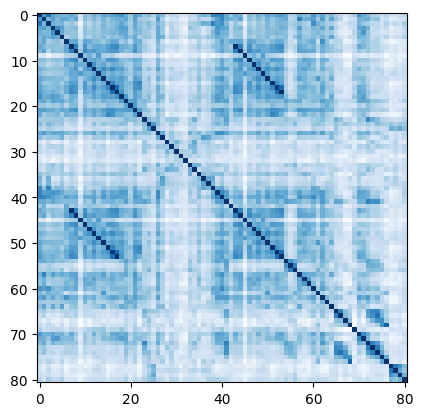

In [46]:
# # Generate segments from 10 news articles and turn into chunks
# segments = gen_segments("topic", "test")
# sentences = create_sentences(segments, MIN_WORDS=20, MAX_WORDS=80)
# chunks = create_chunks(sentences, CHUNK_LENGTH=5, STRIDE=1)
# chunks_text = [chunk['text'] for chunk in chunks]

# # Run Stage 1 Summarizing
# stage_1_outputs = summarize_stage_1(chunks_text)['stage_1_outputs']
# # Split the titles and summaries
# stage_1_summaries = [e['summary'] for e in stage_1_outputs]
# stage_1_titles = [e['title'] for e in stage_1_outputs]
# num_1_chunks = len(stage_1_summaries)

# # Use OpenAI to embed the summaries and titles. Size of _embeds: (num_chunks x 1536)
# openai_embed = OpenAIEmbeddings()

# summary_embeds = np.array(openai_embed.embed_documents(stage_1_summaries))
# title_embeds = np.array(openai_embed.embed_documents(stage_1_titles))

# # Get similarity matrix between the embeddings of the chunk summaries
# summary_similarity_matrix = np.zeros((num_1_chunks, num_1_chunks))
# summary_similarity_matrix[:] = np.nan

# for row in range(num_1_chunks):
#     for col in range(row, num_1_chunks):
#         # Calculate cosine similarity between the two vectors
#         similarity = 1- cosine(summary_embeds[row], summary_embeds[col])
#         summary_similarity_matrix[row, col] = similarity
#         summary_similarity_matrix[col, row] = similarity

# %matplotlib inline
# # Draw a heatmap with the summary_similarity_matrix
# plt.figure()
# # Color scheme blues
# plt.imshow(summary_similarity_matrix, cmap = 'Blues')

Start time: 2023-10-11 12:11:09.081071
Stage 1 done time 2023-10-11 12:11:27.922404
Best SD: 3.8188130791298667, Best iteration: 1
Stage 2 start time 2023-10-11 12:11:34.135400
Stage 2 done time 2023-10-11 12:11:52.004730


TypeError: unsupported callable

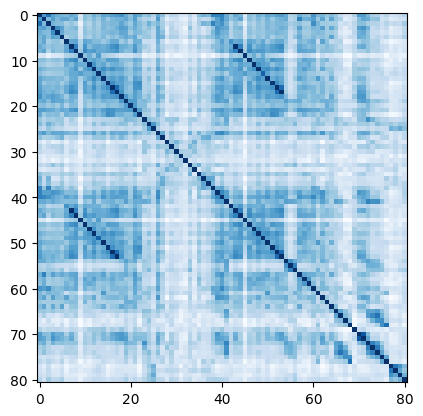

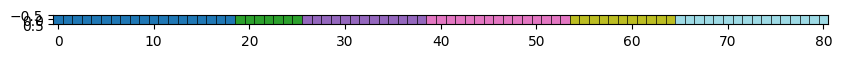

In [50]:

demo = gr.Interface(fn=combined_run("test"), 
                    inputs=[gr.Textbox(label="What do you want your podcast to be about?", placeholder="E.g. 'This week's news in AI'")],
                    outputs= ["text"])
demo.launch(share=True)